somewhere else, do:
```
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
setup -t b1813 ip_diffim
setup -k -r .
scons
```

then you will want to add `$HOME/lsstsw/miniconda/lib/python2.7/site-packages` to your `PYTHONPATH` in order to be able to import `joblib` and friends.

now edit and run the code in here.

In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

In [2]:
import sys
import numpy as np

import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

np.random.seed(666)

In [5]:
## Code updated from lsstsw/build/ip_diffim/tests/dipole.py

## Old code used a double gaussian psf which has the problem that it is pixel-oriented.
## Let's use afwMath.DoubleGaussianFunction2D() instead...
## Change parameterization to pixels - separation (in pixels) and psfWidth (pixels)

## Weird behavior, this fails the dipole lobes are not offset from each other in y direction (hence the +0.05 below...)
## or else we need to use 1,1 in the fpSet.merge() call below (instead of 0,0 which was in the original code)

def createDipole(w=100, h=100, xc=50., yc=50., separation=2.4, rotAngle=0.0, scaling = 100.0, psfWidth=2.0, verbose=False,
                 display=False):  ## fracOffset = 1.2, psfSize=17, 
    # Make random noise image: set image plane to normal distribution
    image = afwImage.MaskedImageF(w,h)
    image.set(0)
    array = image.getImage().getArray()
    array[:,:] = np.random.randn(w,h)
    # Set variance to 1.0 -- TODO, should set variance after adding flux
    var   = image.getVariance()
    var.set(1.0)
        
    # Create Psf for dipole creation and measurement. Need a psf object too (for source detection below)
    psfSize = int(psfWidth * 20.) + 1
    psf = measAlg.DoubleGaussianPsf(psfSize, psfSize, psfWidth, psfWidth*1.75, 0.1) ## 2.0, 3.5, 0.1)
    generator = afwMath.DoubleGaussianFunction2D(psfWidth, psfWidth*1.75, 0.1)    

    psfim = psf.computeImage().convertF()
    psfim *= scaling / psf.computePeak()
    psfw, psfh = psfim.getDimensions()
    psfSum = np.sum(psfim.getArray())

    if display:
        #ds9.mtv(image, frame=1, title="Original image")
        #ds9.mtv(image.getVariance(), frame=2, title="Original variance")
        psf_arr = psf.computeImage().convertF().getArray()
        plt.imshow(np.rot90(psf_arr), cmap='gray', extent=(0,psfSize-1,0,psfSize-1), interpolation='none')
        plt.plot(psfw//2, psfw//2, 'bo')
        plt.title("PSF")
        plt.show()

    # Create the dipole separated by pixels instead of the old fracOffset of Psf FWHM
    # Assume rotAngle is in degrees
    rotAngRad = rotAngle / 180. * np.pi
    array  = image.getImage().getArray()
    xp, yp = xc + separation/2. * np.cos(rotAngRad), yc + separation/2. * np.sin(rotAngRad)
    imPos = np.ndarray( (w,h), buffer=np.array([ generator(i-xp,j-yp) for i in xrange(w) for j in xrange(h) ]) )
    array[:] += imPos/np.max(imPos)*scaling
    psfSum = np.sum(imPos/np.max(imPos)*scaling) # get more accurate input "flux"

    xn, yn = xc - separation/2. * np.cos(rotAngRad), yc - separation/2. * np.sin(rotAngRad)
    imPos = np.ndarray( (w,h), buffer=np.array([ generator(i-xn,j-yn) for i in xrange(w) for j in xrange(h) ]) )
    array[:] -= imPos/np.max(imPos)*scaling
    
    if verbose:
        print 'INPUT CENTROID: ', xc, yc
        print 'INPUT ANGLE: ', rotAngle, rotAngRad
        print 'INPUT POSITIVE CENTROID:', xp, yp
        print 'INPUT NEGATIVE CENTROID:', xn, yn
    dipoleCenters = {'pos': (xp, yp), 'neg': (xn, yn)}

    # Create an exposure, detect positive and negative peaks separately
    # Need to create a psf object anyway, so that's why we did it above, same parameters as the function.
    
    exp = afwImage.makeExposure(image)
    exp.setPsf(psf)

    if display:
        #ds9.mtv(image, frame=3, title="With dipole")
        img_arr, mask_arr, var_arr = exp.getMaskedImage().getArrays()
        plt.title("Original image with dipole")
        plt.imshow(np.rot90(img_arr), vmin=np.min(img_arr), vmax=np.max(img_arr), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.plot(xp, yp, 'bx')
        plt.plot(xn, yn, 'bx')
        ##plt.show()
    
    config = measAlg.SourceDetectionConfig()
    config.thresholdPolarity = "both"
    config.reEstimateBackground = True
    schema = afwTable.SourceTable.makeMinimalSchema()
    task = measAlg.SourceDetectionTask(schema, config=config)
    table = afwTable.SourceTable.make(schema)
    results = task.makeSourceCatalog(table, exp)
#     if display:
#         ds9.mtv(image, frame=4, title="Detection plane")
        
    # Merge them together
    assert(len(results.sources) == 2)
    fpSet = results.fpSets.positive
    fpSet.merge(results.fpSets.negative, 1, 1, False) ## note used to be tGrow=0, rGrow=0, but sometimes sources were not merged.
    sources = afwTable.SourceCatalog(table)
    fpSet.makeSources(sources)
    assert(len(sources) == 1)
    s = sources[0]
    assert(len(s.getFootprint().getPeaks()) == 2)

    if verbose:
        for pk in s.getFootprint().getPeaks():
            print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx()

    if display:
        ## first overlay the fp centers on the input image and show it.
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIy(), pk.getIx(), 'rx')
        plt.show()

        img_arr, mask_arr, var_arr = exp.getMaskedImage().getArrays()
        plt.title("Detection plane")
        plt.imshow(np.rot90(mask_arr), vmin=-100, vmax=100, cmap='gray', extent=(0,99,0,99), interpolation='none')
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIy(), pk.getIx(), 'rx')
        plt.show()
        
    return psf, psfSum, exp, s, dipoleCenters

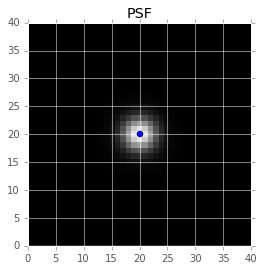

INPUT CENTROID:  50 50
INPUT ANGLE:  0.0 0.0
INPUT POSITIVE CENTROID: 50.1 50.0
INPUT NEGATIVE CENTROID: 49.9 50.0
FOOTPRINT CENTER: 53 50
FOOTPRINT CENTER: 47 50


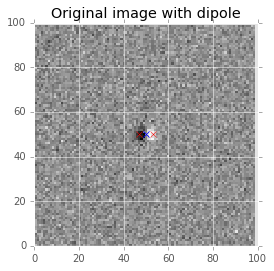

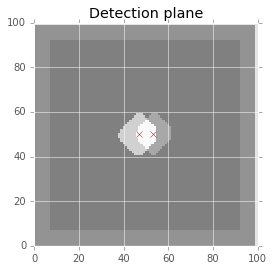

2988.01722374 {'neg': (49.899999999999999, 50.0), 'pos': (50.100000000000001, 50.0)}
CENTROID:  (50.0, 50.0)


In [15]:
#w, h = 100, 100 # size of image
#xc, yc = 50, 50 # location of center of dipole
psf, psfSum, exposure, s, dipoleCenters = createDipole(100, 100, 50, 50, separation=0.2, rotAngle=0., verbose=True, display=True)
print psfSum, dipoleCenters
dipoleCentroid = (np.mean([dipoleCenters['neg'][0], dipoleCenters['pos'][0]]), np.mean([dipoleCenters['neg'][1], dipoleCenters['pos'][1]]))
print 'CENTROID: ', dipoleCentroid

In [16]:
## I think this is the meat of the code that runs the measurement. How do I get the complete set of (fitted) parameters out? 
## THat is the question!
## OK, figured it out, see below...
def measureDipole(s, exp):
    msConfig = ipDiffim.DipoleMeasurementConfig()
    schema = afwTable.SourceTable.makeMinimalSchema()
    schema.addField("centroid_x", type=float)
    schema.addField("centroid_y", type=float)
    schema.addField("centroid_flag", type='Flag')
    task = ipDiffim.DipoleMeasurementTask(schema, config=msConfig)
    measCat = afwTable.SourceCatalog(schema)
    measCat.defineCentroid("centroid")
    source = measCat.addNew()
    source.set("centroid_x", dipoleCentroid[0])
    source.set("centroid_y", dipoleCentroid[1])
    source.setFootprint(s.getFootprint())

    #print 'DIPOLE: ', source.get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
    # Then run the default SFM task.  Results not checked
    task.run(measCat, exp)
    return measCat  ##[0] 

OK, I see that measureDipole is slow because of the psf fitting - in DipoleAlgorithms.cc .
Why is it slow? Possible reasons:

1. `PsfDipoleFlux::chi2()` computes the PSF *image* (pos. and neg.) to compute the model, rather than using something like `afwMath.DoubleGaussianFunction2D()` as I do above. Or if that is not possible (may need to use a pixelated input PSF) then speed up the computation of the dipole model image (right now it uses multiple vectorized function calls).
2. It spends a lot of time floating around near the minimum and perhaps can be cut off more quickly (note this could be caused by (1.)
3. Perhaps its starting parameters (derived from the naive coordinates) could be made more accurate. At least it looks like the starting flux values are being set way too low (looks like +/- 22.0, should be ~3000 -- how is that being set?)
4. it computes chi2 over the entire subimage (confirm this?) rather than the inner 2,3,4, or 5 sigma of the PSF (or even better within the source's footprint(s)

Need to check out -- maybe because dipole fit is so slow, it's not enabled in the main pipelines, thus it uses the naive method by default which is inaccurate.

Note: It seems that the dipole fit is a lot faster for dipoles of greater separation than for those that are closer (it seems the optimization [minuit]) takes longer to converge).

But for now, let's just test the algorithm and worry about timing later.

In [17]:
#print 'DIPOLE: ' + s.get(dipoleFlag)
sources = measureDipole(s, exposure)
print 'DIPOLE: ', sources[0].get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
source = sources[0]
fp     = source.getFootprint()
peaks  = fp.getPeaks()
speaks = [(p.getPeakValue(), p) for p in peaks]
speaks.sort()
dpeaks = [speaks[0][1], speaks[-1][1]]
print dpeaks
##print source.schema
print source.getCentroid() ## This just returns the values set in the "source.set("centroid_x", xc), ..." lines... ??
print source.get("ip_diffim_NaiveDipoleCentroid_pos_x"), source.get("ip_diffim_NaiveDipoleCentroid_pos_y"), \
    source.get("ip_diffim_NaiveDipoleCentroid_neg_x"), source.get("ip_diffim_NaiveDipoleCentroid_neg_y")
print source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), \
    source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y")
print source.get("ip_diffim_PsfDipoleFlux_pos_flux"), source.get("ip_diffim_PsfDipoleFlux_neg_flux")

DIPOLE:  0.0
[22: (50,47)  (50.000,47.000), 21: (50,53)  (50.000,53.000)]
(50, 50)
50.0375099182 52.8222312927 50.0186157227 47.1446914673
49.9313717525 50.852476568 49.8565311379 49.0583407428
342.984249869 -363.969523588


In [18]:
## provides (S/N, position, orientation) of measured dipoles
dpAnalysis = ipDiffim.DipoleAnalysis()
sn, centroid, orientation = dpAnalysis(source)
print sn, centroid, orientation

3.03535455718 (49.894, 49.955) 0.0416898 rad


In [19]:
## deblend a source as a dipole, and return a new source with deblended footprints.
dpDeblender = ipDiffim.DipoleDeblender()
deblendedSource = dpDeblender(source, exposure)
print deblendedSource.getCentroid()
print deblendedSource.get("ip_diffim_NaiveDipoleCentroid_pos_x"), deblendedSource.get("ip_diffim_NaiveDipoleCentroid_pos_y"), \
    deblendedSource.get("ip_diffim_NaiveDipoleCentroid_neg_x"), deblendedSource.get("ip_diffim_NaiveDipoleCentroid_neg_y")
print deblendedSource.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), deblendedSource.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), \
    deblendedSource.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), deblendedSource.get("ip_diffim_PsfDipoleFlux_neg_centroid_y")
print deblendedSource.get("ip_diffim_PsfDipoleFlux_pos_flux"), deblendedSource.get("ip_diffim_PsfDipoleFlux_neg_flux")

(50, 50)
50.0375099182 52.8222312927 50.0186157227 47.1446914673
49.9313717525 50.852476568 49.8565311379 49.0583407428
342.984249869 -363.969523588


In [20]:
# Recreate the simultaneous joint Psf fit in python
## This just fits for the flux of the dipole lobes, given a pair of input centroids.
def _makeModel(exposure, psf, fp, negCenter, posCenter, display=False):
    negPsf = psf.computeImage(negCenter).convertF()
    posPsf = psf.computeImage(posCenter).convertF()
    negPeak = psf.computePeak(negCenter)
    posPeak = psf.computePeak(posCenter)
    negPsf /= negPeak
    posPsf /= posPeak

    model    = afwImage.ImageF(fp.getBBox())
    negModel = afwImage.ImageF(fp.getBBox())
    posModel = afwImage.ImageF(fp.getBBox())

    # The center of the Psf should be at negCenter, posCenter
    negPsfBBox = negPsf.getBBox()
    posPsfBBox = posPsf.getBBox()
    modelBBox  = model.getBBox()

    # Portion of the negative Psf that overlaps the montage
    negOverlapBBox = afwGeom.Box2I(negPsfBBox)
    negOverlapBBox.clip(modelBBox)
    #self.assertFalse(negOverlapBBox.isEmpty())

    # Portion of the positivePsf that overlaps the montage
    posOverlapBBox = afwGeom.Box2I(posPsfBBox)
    posOverlapBBox.clip(modelBBox)
    #self.assertFalse(posOverlapBBox.isEmpty())

    negPsfSubim    = type(negPsf)(negPsf, negOverlapBBox)
    modelSubim     = type(model)(model, negOverlapBBox)
    negModelSubim  = type(negModel)(negModel, negOverlapBBox)
    modelSubim    += negPsfSubim  # just for debugging
    negModelSubim += negPsfSubim  # for fitting

    posPsfSubim    = type(posPsf)(posPsf, posOverlapBBox)
    modelSubim     = type(model)(model, posOverlapBBox)
    posModelSubim  = type(posModel)(posModel, posOverlapBBox)
    modelSubim    += posPsfSubim
    posModelSubim += posPsfSubim

    data = afwImage.ImageF(exposure.getMaskedImage().getImage(), fp.getBBox())
    var = afwImage.ImageF(exposure.getMaskedImage().getVariance(), fp.getBBox())
    matrixNorm = 1. / np.sqrt(np.median(var.getArray()))

    posPsfSum = np.sum(posPsf.getArray())
    negPsfSum = np.sum(negPsf.getArray())

    M = np.array((np.ravel(negModel.getArray()), np.ravel(posModel.getArray()))).T.astype(np.float64)
    B = np.array((np.ravel(data.getArray()))).astype(np.float64)
    M *= matrixNorm
    B *= matrixNorm

    # Numpy solution
    fneg0, fpos0 = np.linalg.lstsq(M, B)[0]

    # Afw solution
    lsq = afwMath.LeastSquares.fromDesignMatrix(M, B, afwMath.LeastSquares.DIRECT_SVD)
    fneg, fpos = lsq.getSolution()

    # Should be exaxtly the same as each other
    #self.assertAlmostEqual(1e-2*fneg0,  1e-2*fneg)
    #self.assertAlmostEqual(1e-2*fpos0,  1e-2*fpos)

    # Recreate model
    fitted  = afwImage.ImageF(fp.getBBox())
    negFit  = type(negPsf)(negPsf, negOverlapBBox, afwImage.PARENT, True)
    negFit *= float(fneg)
    posFit  = type(posPsf)(posPsf, posOverlapBBox, afwImage.PARENT, True)
    posFit *= float(fpos)

    fitSubim  = type(fitted)(fitted, negOverlapBBox)
    fitSubim += negFit
    fitSubim  = type(fitted)(fitted, posOverlapBBox)
    fitSubim += posFit
    
    if display:
    #    ds9.mtv(model, frame=5, title="Unfitted model")
    #    ds9.mtv(data, frame=6, title="Data")
        fig = plt.figure()
        a = fig.add_subplot(1,3,1)
        plt.imshow(np.rot90(model.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Unfitted model (footprint?)')
        #plt.show()
        a = fig.add_subplot(1,3,2)
        plt.imshow(np.rot90(data.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Data')
        #plt.show()

    #if display:
    #    ds9.mtv(fitted, frame=7, title="Fitted model")
        a = fig.add_subplot(1,3,3)
        plt.imshow(np.rot90(fitted.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Fitted model')
        plt.show()

    fitted   -= data

    if display:
    #    ds9.mtv(fitted, frame=8, title="Residuals")
        plt.imshow(np.rot90(fitted.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Residuals')
        plt.show()

    fitted   *= fitted
    fitted   /= var

    if display:
    #    ds9.mtv(fitted, frame=9, title="Chi2")
        plt.imshow(np.rot90(fitted.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Chi2')
        plt.show()

    return fneg, negPsfSum, fpos, posPsfSum, fitted

(50, 53) (50, 47)


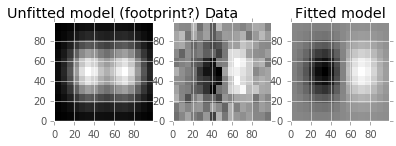

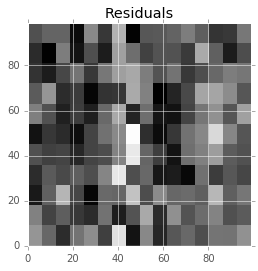

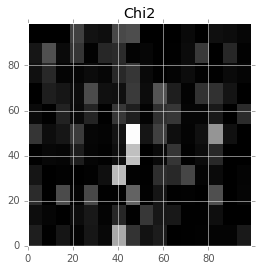

0.0521373017655 0.0446814053608


In [21]:
negCenter = afwGeom.Point2D(dpeaks[0].getFx(), dpeaks[0].getFy())
posCenter = afwGeom.Point2D(dpeaks[1].getFx(), dpeaks[1].getFy())
print posCenter, negCenter

fneg, negPsfSum, fpos, posPsfSum, residIm = _makeModel(exposure, psf, fp, negCenter, posCenter, display=True)

# Should be close to the same as the inputs; as fracOffset
# gets smaller this will be worse.
print -1e-2*fneg,  1e-2*fpos

## Looks like ACB's test code uses the integral value for the naive dipole fitted peak centroid...?

(49.931, 50.852) (49.857, 49.058)


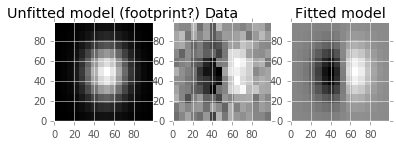

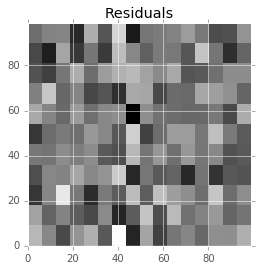

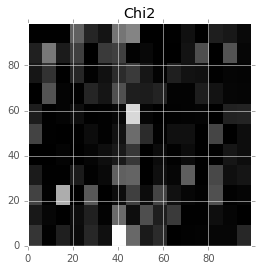

0.121950328248 0.114922590727


In [22]:
negCenter = afwGeom.Point2D(source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"))
posCenter = afwGeom.Point2D(source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"))
print posCenter, negCenter

fneg, negPsfSum, fpos, posPsfSum, residIm = _makeModel(exposure, psf, fp, negCenter, posCenter, display=True)

# Should be close to the same as the inputs
print -1e-2*fneg,  1e-2*fpos